1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


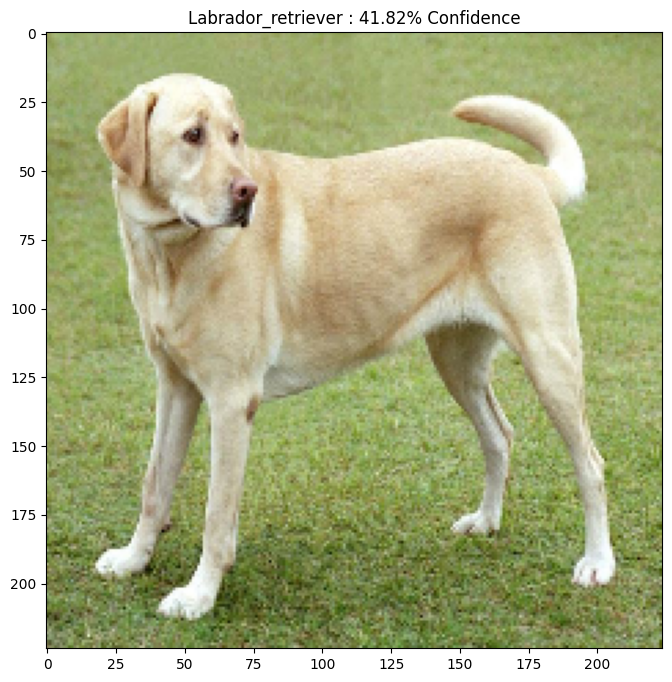

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


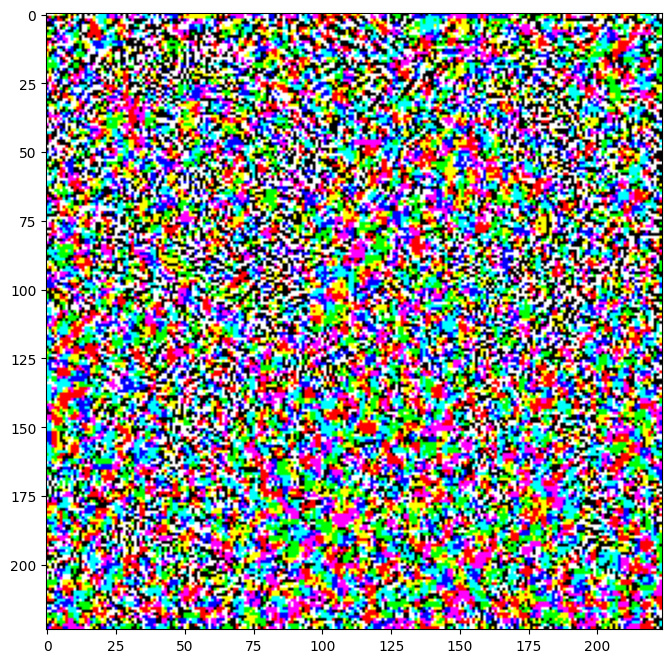

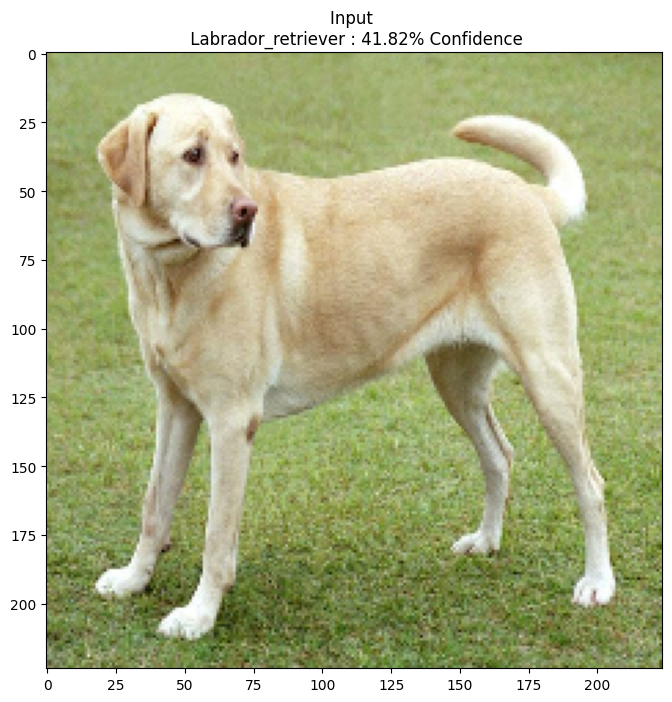

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


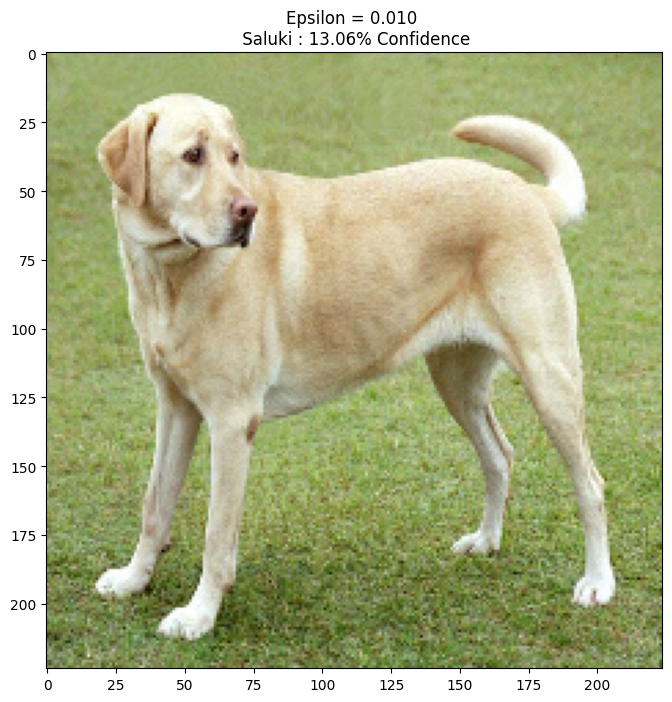

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


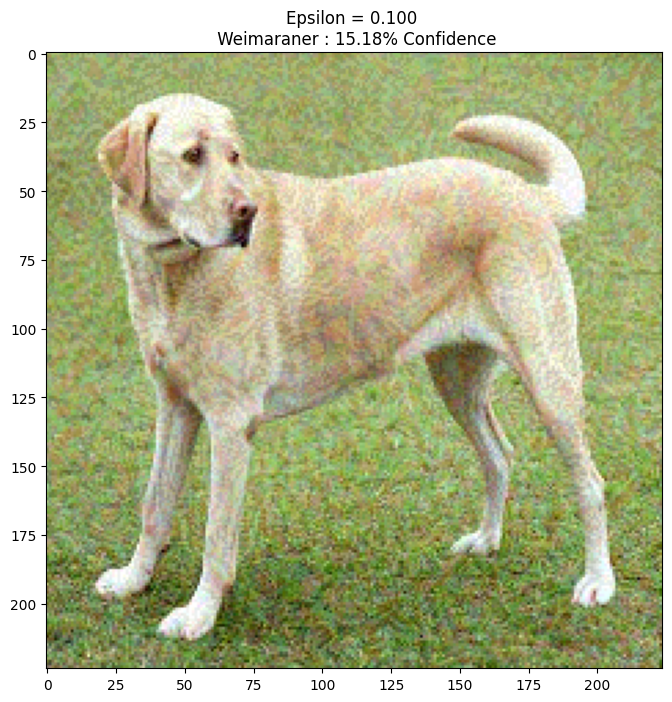

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


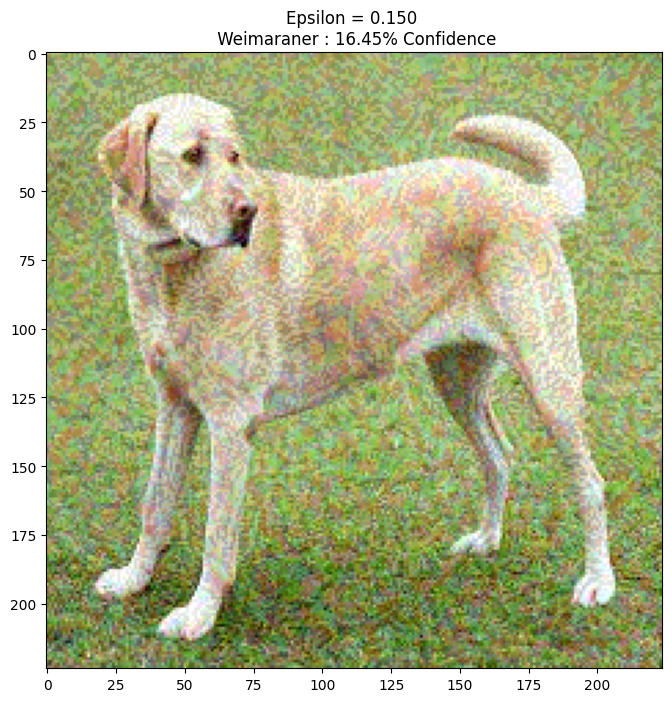

In [3]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

pretrained_model = tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Helper function to preprocess the image so that it can be inputted in MobileNetV2


def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector


def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]


# Image path for Labrador Retriever
image_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

loss_object = tf.keras.losses.CategoricalCrossentropy()


def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad


# Use the model's predicted output as the target label
prediction = pretrained_model.predict(image)
label = tf.one_hot(tf.argmax(prediction[0]), prediction.shape[-1])
label = tf.reshape(label, (1, prediction.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]


def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(
        description, label, confidence*100))
    plt.show()


epsilons = [0, 0.01, 0.1, 0.15]

descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])


Original Image - Min: -1.0, Max: 1.0


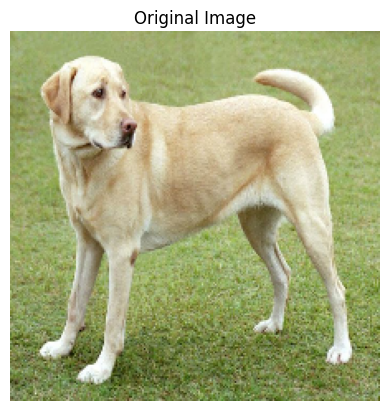

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
Adversarial Image at iteration 1 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 2 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 3 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 4 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 5 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 6 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 7 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 8 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 9 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 10 - Min: -1.0, Max: 1.0
Final Adversarial Image - Min: -1.0, Max: 1.0


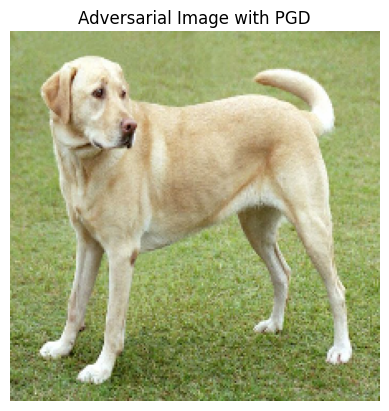

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050000027..0.050000027].


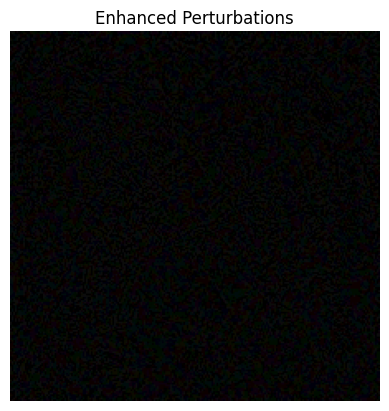

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def print_pixel_range(image, description):
    print(f"{description} - Min: {tf.reduce_min(image).numpy()}, Max: {tf.reduce_max(image).numpy()}")

def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

def decode_predictions(preds):
    decoded = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=1)[0][0]
    label = decoded[1]
    confidence = decoded[2]
    return label, confidence

def display_images(image, description):
    plt.imshow(image)  # Display without additional scaling
    plt.title(description)
    plt.axis('off')
    plt.show()

def load_model():
    model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
    model.trainable = False
    return model

def create_adversarial_pattern(model, loss_object, input_image, input_label, epsilon=0.005, num_iterations=10, alpha=0.001):
    adv_image = tf.identity(input_image)  # Make a copy of the input image

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(adv_image)
            loss = loss_object(input_label, prediction)
        
        gradient = tape.gradient(loss, adv_image)
        signed_grad = tf.sign(gradient)
        adv_image = adv_image + alpha * signed_grad
        adv_image = tf.clip_by_value(adv_image, input_image - epsilon, input_image + epsilon)
        adv_image = tf.clip_by_value(adv_image, -1.0, 1.0)  # Ensure correct clipping for normalized values
        
        # Print pixel range of the intermediate adversarial image
        print_pixel_range(adv_image, f"Adversarial Image at iteration {i+1}")

    return adv_image

def denormalize(image):
    return (image + 1.0) / 2.0

# Load and preprocess image
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 
                                     'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)

# Print pixel range of the original image
print_pixel_range(image, "Original Image")

# Load model
model = load_model()

# Display the original image
display_images(denormalize(image[0]), 'Original Image')

# Generate adversarial pattern using PGD
loss_object = tf.keras.losses.categorical_crossentropy
prediction = model.predict(image)
label = tf.one_hot(tf.argmax(prediction[0]), prediction.shape[-1])
label = tf.reshape(label, (1, prediction.shape[-1]))

# Generate adversarial image
adv_image = create_adversarial_pattern(model, loss_object, image, label)

# Print pixel range of the final adversarial image
print_pixel_range(adv_image, "Final Adversarial Image")

# Denormalize and display the adversarial image
display_images(denormalize(adv_image[0]), 'Adversarial Image with PGD')

# Visualize the perturbations with enhanced contrast
perturbations = adv_image - image
enhanced_perturbations = perturbations * 10  # Enhance contrast for better visibility
display_images(enhanced_perturbations[0], 'Enhanced Perturbations')

In [ ]:
!which python
!which pip

In [ ]:
!where python
!where pip

In [ ]:
!pip cache purge
!pip install numpy tensorflow

In [ ]:

!pip install tensorflow 

In [ ]:
import numpy as np
import tensorflow as tf

print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

In [ ]:
pip install --upgrade numpy tensorflow

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from methods.fgsm import create_adversarial_pattern
from models.mobilenet import load_mobilenet_model, preprocess_image, decode_predictions

def display_image(image, description, model):
    probs = model.predict(image)
    _, label, confidence = decode_predictions(probs)
    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence * 100))
    plt.show()

def main():
    # Load model
    model = load_mobilenet_model()

    # Load and preprocess image
    image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw)
    image = preprocess_image(image)

    # Display original image and prediction
    display_image(image, 'Original Image', model)

    # Create adversarial pattern
    prediction = model.predict(image)
    label = tf.one_hot(tf.argmax(prediction[0]), prediction.shape[-1])
    label = tf.reshape(label, (1, prediction.shape[-1]))

    perturbations = create_adversarial_pattern(image, label, model)

    # Use a single epsilon value for the adversarial example
    epsilon = 0.01
    adv_image = image + epsilon * perturbations
    adv_image = tf.clip_by_value(adv_image, -1, 1)
    description = 'Adversarial Image with Epsilon = {:0.3f}'.format(epsilon)
    display_image(adv_image, description, model)

if __name__ == "__main__":
    main()

In [ ]:
conda update tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
from methods.fgsm import create_adversarial_pattern
from models.mobilenet import load_mobilenet_model, preprocess_image, decode_predictions
import tensorflow_datasets as tfds

def evaluate_dataset(dataset, model):
    correct_predictions = 0
    total_predictions = 0

    for image_batch, label_batch in dataset:
        predictions = model.predict(image_batch)
        predicted_labels = np.argmax(predictions, axis=-1)
        correct_predictions += np.sum(predicted_labels == label_batch)
        total_predictions += image_batch.shape[0]

    accuracy = correct_predictions / total_predictions
    return accuracy

def generate_adversarial_dataset(dataset, model, epsilon=0.01):
    adversarial_images = []
    adversarial_labels = []

    for image_batch, label_batch in dataset:
        for image, label in zip(image_batch, label_batch):
            image = tf.expand_dims(image, axis=0)  # Add batch dimension
            prediction = model.predict(image)
            one_hot_label = tf.one_hot(label, prediction.shape[-1])
            one_hot_label = tf.reshape(one_hot_label, (1, -1))  # Ensure it has the correct shape
            perturbations = create_adversarial_pattern(image, one_hot_label, model)
            adv_image = image + epsilon * perturbations
            adv_image = tf.clip_by_value(adv_image, -1, 1)
            adversarial_images.append(adv_image[0])
            adversarial_labels.append(label)

    adversarial_images = np.array(adversarial_images)
    adversarial_labels = np.array(adversarial_labels)
    return tf.data.Dataset.from_tensor_slices((adversarial_images, adversarial_labels)).batch(32)

def preprocess_imagenet_images(images):
    images = tf.image.resize(images, (224, 224))  # Resize to match MobileNet input size
    images = tf.keras.applications.mobilenet.preprocess_input(images)  # Normalize using MobileNet preprocessing
    return images

def main():
    # Load the pre-trained MobileNet model
    model = load_mobilenet_model()

    # Load and preprocess a subset of the ImageNet validation dataset
    imagenet_val, info = tfds.load('imagenet2012', split='validation[:1%]', with_info=True, as_supervised=True)
    imagenet_val = imagenet_val.take(100)  # Take only 100 samples
    imagenet_val = imagenet_val.map(lambda img, label: (preprocess_imagenet_images(img), label)).batch(32)

    # Evaluate the model on the original dataset
    original_accuracy = evaluate_dataset(imagenet_val, model)
    print('Original Accuracy: {:.2f}%'.format(original_accuracy * 100))

    # Generate adversarial examples
    adversarial_test_dataset = generate_adversarial_dataset(imagenet_val, model)

    # Evaluate the model on the adversarial dataset
    adversarial_accuracy = evaluate_dataset(adversarial_test_dataset, model)
    print('Adversarial Accuracy: {:.2f}%'.format(adversarial_accuracy * 100))

if __name__ == "__main__":
    main()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from methods.fgsm import create_adversarial_pattern
from models.mobilenet import load_mobilenet_model, preprocess_image, decode_predictions

def display_images(sample_images, descriptions, model):
    for idx, (original, adversarial) in enumerate(sample_images):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        original_probs = model.predict(original)
        _, original_label, original_confidence = decode_predictions(original_probs)
        plt.imshow(original[0] * 0.5 + 0.5)
        plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[idx][0], original_label, original_confidence * 100))

        plt.subplot(1, 2, 2)
        adversarial_probs = model.predict(adversarial)
        _, adv_label, adv_confidence = decode_predictions(adversarial_probs)
        plt.imshow(adversarial[0] * 0.5 + 0.5)
        plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[idx][1], adv_label, adv_confidence * 100))

        plt.show()

def main():
    method_name = "FGSM"
    model_name = "MobileNet"

    # Load model
    model = load_mobilenet_model()

    # Load CIFAR-10 dataset
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
    test_images = test_images[:100]  # Use a subset for demonstration purposes
    test_labels = test_labels[:100]

    # Define epsilon
    epsilon = 0.1

    sample_images = []
    descriptions = []

    for i in range(len(test_images)):
        image = test_images[i]
        image = preprocess_image(image)
        
        # Create adversarial image
        prediction = model.predict(image)
        perturbations = create_adversarial_pattern(image, prediction, model)
        adv_image = image + epsilon * perturbations
        adv_image = tf.clip_by_value(adv_image, -1, 1)

        # Store images and descriptions for display
        sample_images.append((image, adv_image))
        descriptions.append(("Original Image", "Adversarial Image"))

    # Display sample images with predictions
    display_images(sample_images, descriptions, model)

if __name__ == "__main__":
    main()